In [1]:
from tqdm.auto import tqdm
import torch
from utils.visualization import plot_reverse_diffusion
torch.cuda.empty_cache()

In [2]:
import math
from inspect import isfunction
from functools import partial

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from einops import rearrange, reduce
from einops.layers.torch import Rearrange

import torch
from torch import nn, einsum
import torch.nn.functional as F

In [3]:
def exists(x):
    return x is not None

def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d


def num_to_groups(num, divisor):
    groups = num // divisor
    remainder = num % divisor
    arr = [divisor] * groups
    if remainder > 0:
        arr.append(remainder)
    return arr


class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x


def Upsample(dim, dim_out=None):
    return nn.Sequential(
        nn.Upsample(scale_factor=2, mode="nearest"),
        nn.Conv2d(dim, default(dim_out, dim), 3, padding=1),
    )


def Downsample(dim, dim_out=None):
    # No More Strided Convolutions or Pooling
    return nn.Sequential(
        Rearrange("b c (h p1) (w p2) -> b (c p1 p2) h w", p1=2, p2=2),
        nn.Conv2d(dim * 4, default(dim_out, dim), 1),
    )


In [4]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings


In [5]:
class WeightStandardizedConv2d(nn.Conv2d):
    """
    https://arxiv.org/abs/1903.10520
    weight standardization purportedly works synergistically with group normalization
    """

    def forward(self, x):
        eps = 1e-5 if x.dtype == torch.float32 else 1e-3

        weight = self.weight
        mean = reduce(weight, "o ... -> o 1 1 1", "mean")
        var = reduce(weight, "o ... -> o 1 1 1", partial(torch.var, unbiased=False))
        normalized_weight = (weight - mean) / (var + eps).rsqrt()

        return F.conv2d(
            x,
            normalized_weight,
            self.bias,
            self.stride,
            self.padding,
            self.dilation,
            self.groups,
        )


class Block(nn.Module):
    def __init__(self, dim, dim_out, groups=8):
        super().__init__()
        self.proj = WeightStandardizedConv2d(dim, dim_out, 3, padding=1)
        self.norm = nn.GroupNorm(groups, dim_out)
        self.act = nn.SiLU()

    def forward(self, x, scale_shift=None):
        x = self.proj(x)
        x = self.norm(x)

        if exists(scale_shift):
            scale, shift = scale_shift
            x = x * (scale + 1) + shift

        x = self.act(x)
        return x


class ResnetBlock(nn.Module):
    """https://arxiv.org/abs/1512.03385"""

    def __init__(self, dim, dim_out, *, time_emb_dim=None, groups=8):
        super().__init__()
        self.mlp = (
            nn.Sequential(nn.SiLU(), nn.Linear(time_emb_dim, dim_out * 2))
            if exists(time_emb_dim)
            else None
        )

        self.block1 = Block(dim, dim_out, groups=groups)
        self.block2 = Block(dim_out, dim_out, groups=groups)
        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb=None):
        scale_shift = None
        if exists(self.mlp) and exists(time_emb):
            time_emb = self.mlp(time_emb)
            time_emb = rearrange(time_emb, "b c -> b c 1 1")
            scale_shift = time_emb.chunk(2, dim=1)

        h = self.block1(x, scale_shift=scale_shift)
        h = self.block2(h)
        return h + self.res_conv(x)


In [6]:
class Attention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )
        q = q * self.scale

        sim = einsum("b h d i, b h d j -> b h i j", q, k)
        sim = sim - sim.amax(dim=-1, keepdim=True).detach()
        attn = sim.softmax(dim=-1)

        out = einsum("b h i j, b h d j -> b h i d", attn, v)
        out = rearrange(out, "b h (x y) d -> b (h d) x y", x=h, y=w)
        return self.to_out(out)

class LinearAttention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)

        self.to_out = nn.Sequential(nn.Conv2d(hidden_dim, dim, 1), 
                                    nn.GroupNorm(1, dim))

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )

        q = q.softmax(dim=-2)
        k = k.softmax(dim=-1)

        q = q * self.scale
        context = torch.einsum("b h d n, b h e n -> b h d e", k, v)

        out = torch.einsum("b h d e, b h d n -> b h e n", context, q)
        out = rearrange(out, "b h c (x y) -> b (h c) x y", h=self.heads, x=h, y=w)
        return self.to_out(out)


In [7]:
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.GroupNorm(1, dim)

    def forward(self, x):
        x = self.norm(x)
        return self.fn(x)


In [8]:
class Unet(nn.Module):
    def __init__(
        self,
        dim,
        init_dim=None,
        out_dim=None,
        dim_mults=(1, 2, 4, 8),
        channels=3,
        self_condition=False,
        resnet_block_groups=4,
    ):
        super().__init__()

        # determine dimensions
        self.channels = channels
        self.self_condition = self_condition
        input_channels = channels * (2 if self_condition else 1)

        init_dim = default(init_dim, dim)
        self.init_conv = nn.Conv2d(input_channels, init_dim, 1, padding=0) # changed to 1 and 0 from 7,3

        dims = [init_dim, *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))

        block_klass = partial(ResnetBlock, groups=resnet_block_groups)

        # time embeddings
        time_dim = dim * 4

        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(dim),
            nn.Linear(dim, time_dim),
            nn.GELU(),
            nn.Linear(time_dim, time_dim),
        )

        # layers
        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out)

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append(
                nn.ModuleList(
                    [
                        block_klass(dim_in, dim_in, time_emb_dim=time_dim),
                        block_klass(dim_in, dim_in, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                        Downsample(dim_in, dim_out)
                        if not is_last
                        else nn.Conv2d(dim_in, dim_out, 3, padding=1),
                    ]
                )
            )

        mid_dim = dims[-1]
        self.mid_block1 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_block2 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out)):
            is_last = ind == (len(in_out) - 1)

            self.ups.append(
                nn.ModuleList(
                    [
                        block_klass(dim_out + dim_in, dim_out, time_emb_dim=time_dim),
                        block_klass(dim_out + dim_in, dim_out, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                        Upsample(dim_out, dim_in)
                        if not is_last
                        else nn.Conv2d(dim_out, dim_in, 3, padding=1),
                    ]
                )
            )

        self.out_dim = default(out_dim, channels)

        self.final_res_block = block_klass(dim * 2, dim, time_emb_dim=time_dim)
        self.final_conv = nn.Conv2d(dim, self.out_dim, 1)

    def forward(self, x, time, x_self_cond=None):
        if self.self_condition:
            x_self_cond = default(x_self_cond, lambda: torch.zeros_like(x))
            x = torch.cat((x_self_cond, x), dim=1)

        x = self.init_conv(x)
        r = x.clone()

        t = self.time_mlp(time)

        h = []

        for block1, block2, attn, downsample in self.downs:
            x = block1(x, t)
            h.append(x)

            x = block2(x, t)
            x = attn(x)
            h.append(x)

            x = downsample(x)

        x = self.mid_block1(x, t)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t)

        for block1, block2, attn, upsample in self.ups:
            x = torch.cat((x, h.pop()), dim=1)
            x = block1(x, t)

            x = torch.cat((x, h.pop()), dim=1)
            x = block2(x, t)
            x = attn(x)

            x = upsample(x)

        x = torch.cat((x, r), dim=1)

        x = self.final_res_block(x, t)
        return self.final_conv(x)


In [9]:
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader, Subset
from torchvision.transforms import Compose, ToTensor, Resize, RandomHorizontalFlip, Lambda


# define image transformations (e.g. using torchvision)
transform = Compose([
    Resize(28*2),
    RandomHorizontalFlip(),
    ToTensor(),
    Lambda(lambda t: (t * 2) - 1)
])

reverse_transform = transforms.Compose([
    transforms.Lambda(lambda t: (t + 1) / 2),
    transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
    transforms.ToPILImage(),
])

dataset = datasets.MNIST(
    root="./data/datasets",
    train=True,
    download=True,
    transform=transform,
    
)
channels, image_size, _ = dataset[0][0].shape
batch_size = 128

dataset = Subset(dataset, indices=torch.arange(0, len(dataset)//2))

print(f'taille dataset: {len(dataset)}')

# create dataloader
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

taille dataset: 30000


In [10]:
from torch.optim import Adam
from models.TemporalUNet import TemporalUNet
from models.DDPM import DDPM


device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
"""
model = TemporalUNet(
    in_channels=1,
    out_channels=1,
    channel_scale=image_size,
    channels_mult=(1, 2, 4,)
)
"""
model = Unet(
    dim=image_size,
    channels=channels,
    dim_mults=(1, 2, 4,)
)

optimizer = Adam(model.parameters(), lr=1e-3)

diffusion_model = DDPM(denoiser=model, timestep=300, schedule_type='cosine')

### Training

In [ ]:
epochs = 6
losses = []

for epoch in range(epochs):
    training_batches_progress = tqdm(range(len(dataloader)),
                                 desc='Epoch {}/{}'.format(epoch + 1, epochs))
    losses.append(0.0)
    
    for images in dataloader:
        images, _ = images
        images = images.to(device)
    
        optimizer.zero_grad()
        loss = diffusion_model.compute_loss(images)
        loss.backward()
        optimizer.step()
    
        losses[-1] += len(images) * loss.item()
        
        training_batches_progress.update()
    losses[-1] /= len(dataset)
    
    training_batches_progress.set_postfix_str(str(f'Loss: {losses[-1]:.4f}'))
    training_batches_progress.close()

Epoch 1/6:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 2/6:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 3/6:   0%|          | 0/235 [00:00<?, ?it/s]

### Forward process

In [5]:
from utils.visualization import plot_forward_diffusion

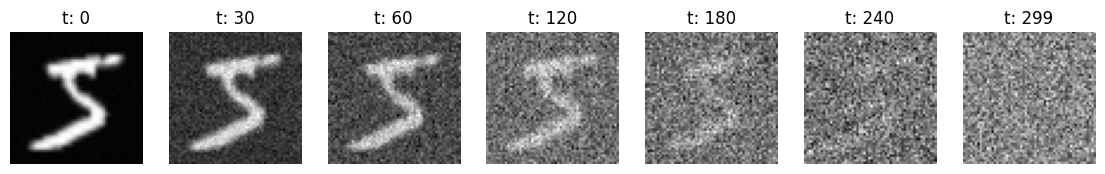

In [6]:
T = diffusion_model.timestep
x_noisy = plot_forward_diffusion(
    diffusion_model, 
    dataset[0][0].to(device), 
    sequence_t=list(map(int, [0, 0.1*T, 0.2*T, 0.4*T, 0.6*T, 0.8*T, T-1]))
)

### Reconstruction

In [7]:
rec_sec_image = diffusion_model.rec_reverse_sampling(x_noisy)

reverse process: 10it [00:00, 50.67it/s]

t: tensor([299], device='cuda:0')
epsilon_theta: tensor([[[[ 1.6204e+00, -6.5230e-01,  1.0127e+00,  ...,  1.2915e+00,
           -1.9288e-01,  2.7725e+00],
          [-5.9386e-01, -9.2174e-01, -1.8979e+00,  ...,  3.3519e+00,
            5.6827e-01, -9.5006e-01],
          [-2.0598e+00,  1.5127e+00, -1.1162e+00,  ..., -1.2155e-01,
           -8.5010e-01, -7.2622e-02],
          ...,
          [ 1.0922e+00, -4.4388e-01, -6.0296e-01,  ...,  5.9647e-01,
           -5.9030e-01,  9.2094e-01],
          [-1.8495e+00, -2.7789e-03,  1.9296e+00,  ...,  5.8683e-01,
           -9.7240e-01,  1.6030e+00],
          [ 1.6960e+00,  3.6310e-01, -6.3260e-02,  ..., -2.1075e+00,
           -4.4157e-01,  4.2896e-01]]]], device='cuda:0')

t: tensor([298], device='cuda:0')
epsilon_theta: tensor([[[[-2.7099,  0.0599, -1.3983,  ..., -2.3982, -1.5300, -2.4207],
          [ 0.0965,  0.8181,  1.3544,  ..., -3.0080, -1.7745,  0.3748],
          [ 1.5332, -1.8430,  0.5273,  ...,  0.0544,  0.3980,  0.1610],
        

reverse process: 30it [00:00, 86.66it/s]

t: tensor([289], device='cuda:0')
epsilon_theta: tensor([[[[-2.6873,  0.0639, -1.4659,  ..., -2.3262, -1.4652, -2.3381],
          [ 0.0736,  0.8083,  1.3882,  ..., -3.0960, -1.8145,  0.3855],
          [ 1.5615, -1.8274,  0.4668,  ...,  0.0636,  0.4038,  0.1623],
          ...,
          [-1.3135,  0.0188,  0.2743,  ..., -2.1435, -0.0712, -1.9063],
          [ 0.7913, -0.5254, -2.7053,  ..., -1.4543, -0.0920, -2.3245],
          [-2.2791, -1.2649, -0.8296,  ...,  1.4515, -0.2741, -1.2745]]]],
       device='cuda:0')

t: tensor([288], device='cuda:0')
epsilon_theta: tensor([[[[-2.6891,  0.0637, -1.4659,  ..., -2.3253, -1.4615, -2.3372],
          [ 0.0729,  0.8073,  1.3882,  ..., -3.0968, -1.8104,  0.3852],
          [ 1.5628, -1.8227,  0.4652,  ...,  0.0637,  0.4043,  0.1620],
          ...,
          [-1.3151,  0.0183,  0.2755,  ..., -2.1443, -0.0734, -1.9026],
          [ 0.7934, -0.5258, -2.7083,  ..., -1.4550, -0.0923, -2.3253],
          [-2.2795, -1.2640, -0.8277,  ...,  1.4473,

reverse process: 53it [00:00, 79.98it/s]

epsilon_theta: tensor([[[[-2.6834,  0.0649, -1.4647,  ..., -2.3112, -1.4546, -2.3232],
          [ 0.0726,  0.8067,  1.3890,  ..., -3.0993, -1.8157,  0.3828],
          [ 1.5658, -1.8149,  0.4575,  ...,  0.0654,  0.4057,  0.1684],
          ...,
          [-1.3083,  0.0180,  0.2792,  ..., -2.1374, -0.0808, -1.8961],
          [ 0.7951, -0.5202, -2.7070,  ..., -1.4508, -0.0891, -2.3178],
          [-2.2843, -1.2652, -0.8220,  ...,  1.4483, -0.2818, -1.2703]]]],
       device='cuda:0')

t: tensor([267], device='cuda:0')
epsilon_theta: tensor([[[[-2.6837,  0.0647, -1.4652,  ..., -2.3142, -1.4534, -2.3238],
          [ 0.0723,  0.8065,  1.3888,  ..., -3.1029, -1.8147,  0.3830],
          [ 1.5655, -1.8141,  0.4571,  ...,  0.0652,  0.4055,  0.1679],
          ...,
          [-1.3090,  0.0178,  0.2785,  ..., -2.1363, -0.0808, -1.8966],
          [ 0.7950, -0.5209, -2.7046,  ..., -1.4505, -0.0889, -2.3176],
          [-2.2820, -1.2648, -0.8220,  ...,  1.4484, -0.2817, -1.2708]]]],
       devi

reverse process: 63it [00:00, 64.11it/s]

t: tensor([246], device='cuda:0')
epsilon_theta: tensor([[[[-2.6831,  0.0638, -1.4656,  ..., -2.3110, -1.4526, -2.3219],
          [ 0.0718,  0.8068,  1.3879,  ..., -3.0994, -1.8164,  0.3826],
          [ 1.5658, -1.8148,  0.4577,  ...,  0.0645,  0.4054,  0.1677],
          ...,
          [-1.3110,  0.0186,  0.2769,  ..., -2.1352, -0.0821, -1.8928],
          [ 0.7945, -0.5181, -2.7028,  ..., -1.4490, -0.0897, -2.3162],
          [-2.2839, -1.2640, -0.8241,  ...,  1.4510, -0.2817, -1.2720]]]],
       device='cuda:0')

t: tensor([245], device='cuda:0')
epsilon_theta: tensor([[[[-2.6835,  0.0637, -1.4672,  ..., -2.3129, -1.4524, -2.3217],
          [ 0.0720,  0.8069,  1.3882,  ..., -3.1029, -1.8162,  0.3824],
          [ 1.5658, -1.8145,  0.4577,  ...,  0.0645,  0.4053,  0.1676],
          ...,
          [-1.3119,  0.0184,  0.2772,  ..., -2.1365, -0.0819, -1.8953],
          [ 0.7947, -0.5178, -2.7023,  ..., -1.4493, -0.0899, -2.3179],
          [-2.2834, -1.2636, -0.8241,  ...,  1.4508,

reverse process: 73it [00:01, 54.15it/s]

t: tensor([230], device='cuda:0')
epsilon_theta: tensor([[[[-2.6813,  0.0635, -1.4656,  ..., -2.3117, -1.4523, -2.3216],
          [ 0.0726,  0.8066,  1.3894,  ..., -3.1001, -1.8169,  0.3825],
          [ 1.5668, -1.8158,  0.4578,  ...,  0.0644,  0.4049,  0.1681],
          ...,
          [-1.3096,  0.0186,  0.2772,  ..., -2.1367, -0.0827, -1.8949],
          [ 0.7946, -0.5173, -2.7049,  ..., -1.4495, -0.0897, -2.3164],
          [-2.2832, -1.2650, -0.8235,  ...,  1.4515, -0.2822, -1.2722]]]],
       device='cuda:0')

t: tensor([229], device='cuda:0')
epsilon_theta: tensor([[[[-2.6804,  0.0635, -1.4653,  ..., -2.3115, -1.4516, -2.3224],
          [ 0.0725,  0.8068,  1.3892,  ..., -3.1012, -1.8166,  0.3825],
          [ 1.5668, -1.8146,  0.4578,  ...,  0.0643,  0.4050,  0.1682],
          ...,
          [-1.3099,  0.0185,  0.2771,  ..., -2.1377, -0.0826, -1.8942],
          [ 0.7944, -0.5173, -2.7049,  ..., -1.4487, -0.0896, -2.3166],
          [-2.2842, -1.2658, -0.8233,  ...,  1.4510,

reverse process: 86it [00:01, 68.74it/s]

t: tensor([226], device='cuda:0')
epsilon_theta: tensor([[[[-2.6816,  0.0633, -1.4658,  ..., -2.3125, -1.4520, -2.3216],
          [ 0.0725,  0.8063,  1.3892,  ..., -3.1015, -1.8165,  0.3824],
          [ 1.5671, -1.8153,  0.4579,  ...,  0.0641,  0.4050,  0.1683],
          ...,
          [-1.3097,  0.0187,  0.2771,  ..., -2.1383, -0.0825, -1.8952],
          [ 0.7947, -0.5169, -2.7039,  ..., -1.4486, -0.0897, -2.3171],
          [-2.2827, -1.2652, -0.8234,  ...,  1.4517, -0.2818, -1.2719]]]],
       device='cuda:0')

t: tensor([225], device='cuda:0')
epsilon_theta: tensor([[[[-2.6821,  0.0632, -1.4654,  ..., -2.3100, -1.4513, -2.3205],
          [ 0.0725,  0.8062,  1.3893,  ..., -3.1013, -1.8161,  0.3823],
          [ 1.5668, -1.8160,  0.4581,  ...,  0.0641,  0.4050,  0.1683],
          ...,
          [-1.3100,  0.0188,  0.2771,  ..., -2.1348, -0.0825, -1.8950],
          [ 0.7946, -0.5171, -2.7035,  ..., -1.4490, -0.0897, -2.3169],
          [-2.2829, -1.2640, -0.8236,  ...,  1.4515,

reverse process: 95it [00:01, 56.89it/s]

t: tensor([209], device='cuda:0')
epsilon_theta: tensor([[[[-2.6845,  0.0637, -1.4661,  ..., -2.3105, -1.4517, -2.3230],
          [ 0.0723,  0.8069,  1.3895,  ..., -3.1020, -1.8171,  0.3822],
          [ 1.5672, -1.8146,  0.4579,  ...,  0.0640,  0.4048,  0.1685],
          ...,
          [-1.3105,  0.0187,  0.2769,  ..., -2.1363, -0.0832, -1.8950],
          [ 0.7942, -0.5166, -2.7042,  ..., -1.4476, -0.0900, -2.3165],
          [-2.2835, -1.2649, -0.8236,  ...,  1.4514, -0.2826, -1.2723]]]],
       device='cuda:0')

t: tensor([208], device='cuda:0')
epsilon_theta: tensor([[[[-2.6798,  0.0637, -1.4643,  ..., -2.3111, -1.4517, -2.3197],
          [ 0.0723,  0.8068,  1.3895,  ..., -3.1029, -1.8176,  0.3821],
          [ 1.5670, -1.8146,  0.4579,  ...,  0.0641,  0.4047,  0.1685],
          ...,
          [-1.3110,  0.0188,  0.2768,  ..., -2.1361, -0.0832, -1.8952],
          [ 0.7942, -0.5165, -2.7043,  ..., -1.4490, -0.0900, -2.3159],
          [-2.2830, -1.2653, -0.8241,  ...,  1.4513,

reverse process: 109it [00:01, 71.89it/s]

t: tensor([192], device='cuda:0')
epsilon_theta: tensor([[[[-2.6826,  0.0636, -1.4654,  ..., -2.3133, -1.4526, -2.3233],
          [ 0.0721,  0.8070,  1.3895,  ..., -3.1027, -1.8178,  0.3821],
          [ 1.5668, -1.8161,  0.4578,  ...,  0.0642,  0.4050,  0.1683],
          ...,
          [-1.3100,  0.0183,  0.2770,  ..., -2.1354, -0.0831, -1.8948],
          [ 0.7944, -0.5163, -2.7042,  ..., -1.4492, -0.0897, -2.3148],
          [-2.2828, -1.2660, -0.8229,  ...,  1.4515, -0.2825, -1.2716]]]],
       device='cuda:0')

t: tensor([191], device='cuda:0')
epsilon_theta: tensor([[[[-2.6812,  0.0636, -1.4645,  ..., -2.3111, -1.4525, -2.3214],
          [ 0.0721,  0.8069,  1.3897,  ..., -3.1045, -1.8179,  0.3820],
          [ 1.5671, -1.8149,  0.4578,  ...,  0.0642,  0.4050,  0.1683],
          ...,
          [-1.3096,  0.0183,  0.2770,  ..., -2.1367, -0.0831, -1.8948],
          [ 0.7945, -0.5162, -2.7055,  ..., -1.4494, -0.0896, -2.3178],
          [-2.2832, -1.2653, -0.8230,  ...,  1.4517,

reverse process: 118it [00:01, 58.18it/s]

t: tensor([188], device='cuda:0')
epsilon_theta: tensor([[[[-2.6811,  0.0635, -1.4650,  ..., -2.3109, -1.4508, -2.3214],
          [ 0.0721,  0.8070,  1.3895,  ..., -3.1023, -1.8184,  0.3822],
          [ 1.5666, -1.8137,  0.4578,  ...,  0.0642,  0.4050,  0.1684],
          ...,
          [-1.3076,  0.0183,  0.2770,  ..., -2.1351, -0.0830, -1.8950],
          [ 0.7946, -0.5162, -2.7067,  ..., -1.4487, -0.0897, -2.3179],
          [-2.2813, -1.2652, -0.8233,  ...,  1.4517, -0.2824, -1.2718]]]],
       device='cuda:0')

t: tensor([187], device='cuda:0')
epsilon_theta: tensor([[[[-2.6837,  0.0635, -1.4641,  ..., -2.3093, -1.4522, -2.3238],
          [ 0.0721,  0.8069,  1.3896,  ..., -3.1038, -1.8155,  0.3821],
          [ 1.5669, -1.8146,  0.4579,  ...,  0.0642,  0.4050,  0.1684],
          ...,
          [-1.3101,  0.0183,  0.2770,  ..., -2.1358, -0.0830, -1.8952],
          [ 0.7947, -0.5162, -2.7057,  ..., -1.4484, -0.0896, -2.3165],
          [-2.2845, -1.2644, -0.8228,  ...,  1.4515,

reverse process: 142it [00:02, 66.34it/s]

t: tensor([171], device='cuda:0')
epsilon_theta: tensor([[[[-2.6819,  0.0633, -1.4644,  ..., -2.3103, -1.4522, -2.3216],
          [ 0.0719,  0.8070,  1.3895,  ..., -3.1023, -1.8174,  0.3821],
          [ 1.5671, -1.8144,  0.4578,  ...,  0.0640,  0.4052,  0.1685],
          ...,
          [-1.3099,  0.0182,  0.2771,  ..., -2.1370, -0.0836, -1.8941],
          [ 0.7946, -0.5160, -2.7033,  ..., -1.4482, -0.0895, -2.3152],
          [-2.2824, -1.2642, -0.8224,  ...,  1.4514, -0.2826, -1.2721]]]],
       device='cuda:0')

t: tensor([170], device='cuda:0')
epsilon_theta: tensor([[[[-2.6808,  0.0633, -1.4661,  ..., -2.3113, -1.4518, -2.3237],
          [ 0.0719,  0.8071,  1.3895,  ..., -3.1026, -1.8173,  0.3822],
          [ 1.5669, -1.8137,  0.4579,  ...,  0.0640,  0.4050,  0.1686],
          ...,
          [-1.3083,  0.0182,  0.2771,  ..., -2.1356, -0.0836, -1.8955],
          [ 0.7945, -0.5161, -2.7042,  ..., -1.4493, -0.0895, -2.3150],
          [-2.2828, -1.2653, -0.8220,  ...,  1.4515,

reverse process: 165it [00:02, 70.80it/s]

epsilon_theta: tensor([[[[-2.6802,  0.0632, -1.4644,  ..., -2.3118, -1.4510, -2.3233],
          [ 0.0720,  0.8067,  1.3896,  ..., -3.1044, -1.8160,  0.3822],
          [ 1.5669, -1.8139,  0.4582,  ...,  0.0639,  0.4053,  0.1686],
          ...,
          [-1.3091,  0.0181,  0.2772,  ..., -2.1372, -0.0835, -1.8938],
          [ 0.7944, -0.5158, -2.7059,  ..., -1.4479, -0.0895, -2.3155],
          [-2.2810, -1.2641, -0.8221,  ...,  1.4519, -0.2824, -1.2711]]]],
       device='cuda:0')

t: tensor([151], device='cuda:0')
epsilon_theta: tensor([[[[-2.6826,  0.0632, -1.4655,  ..., -2.3095, -1.4522, -2.3215],
          [ 0.0720,  0.8069,  1.3896,  ..., -3.1022, -1.8160,  0.3822],
          [ 1.5670, -1.8146,  0.4582,  ...,  0.0639,  0.4052,  0.1685],
          ...,
          [-1.3099,  0.0181,  0.2772,  ..., -2.1357, -0.0835, -1.8946],
          [ 0.7946, -0.5157, -2.7026,  ..., -1.4496, -0.0895, -2.3172],
          [-2.2817, -1.2638, -0.8224,  ...,  1.4517, -0.2823, -1.2720]]]],
       devi

reverse process: 175it [00:02, 59.18it/s]

epsilon_theta: tensor([[[[-2.6827,  0.0633, -1.4651,  ..., -2.3100, -1.4520, -2.3209],
          [ 0.0719,  0.8069,  1.3894,  ..., -3.1053, -1.8176,  0.3821],
          [ 1.5669, -1.8150,  0.4580,  ...,  0.0640,  0.4053,  0.1687],
          ...,
          [-1.3102,  0.0182,  0.2770,  ..., -2.1342, -0.0836, -1.8946],
          [ 0.7947, -0.5158, -2.7049,  ..., -1.4502, -0.0894, -2.3162],
          [-2.2826, -1.2657, -0.8221,  ...,  1.4516, -0.2828, -1.2716]]]],
       device='cuda:0')

t: tensor([133], device='cuda:0')
epsilon_theta: tensor([[[[-2.6815,  0.0632, -1.4665,  ..., -2.3101, -1.4506, -2.3223],
          [ 0.0719,  0.8068,  1.3894,  ..., -3.1038, -1.8150,  0.3821],
          [ 1.5669, -1.8143,  0.4580,  ...,  0.0640,  0.4052,  0.1687],
          ...,
          [-1.3079,  0.0182,  0.2770,  ..., -2.1366, -0.0836, -1.8956],
          [ 0.7947, -0.5161, -2.7060,  ..., -1.4485, -0.0894, -2.3167],
          [-2.2817, -1.2651, -0.8216,  ...,  1.4518, -0.2828, -1.2717]]]],
       devi

reverse process: 200it [00:03, 68.70it/s]

epsilon_theta: tensor([[[[-2.6827,  0.0634, -1.4642,  ..., -2.3102, -1.4509, -2.3231],
          [ 0.0718,  0.8068,  1.3894,  ..., -3.1015, -1.8151,  0.3823],
          [ 1.5671, -1.8141,  0.4580,  ...,  0.0639,  0.4051,  0.1688],
          ...,
          [-1.3088,  0.0181,  0.2771,  ..., -2.1357, -0.0838, -1.8942],
          [ 0.7947, -0.5160, -2.7026,  ..., -1.4495, -0.0894, -2.3175],
          [-2.2832, -1.2653, -0.8219,  ...,  1.4518, -0.2827, -1.2716]]]],
       device='cuda:0')

t: tensor([113], device='cuda:0')
epsilon_theta: tensor([[[[-2.6817,  0.0634, -1.4651,  ..., -2.3114, -1.4506, -2.3225],
          [ 0.0719,  0.8067,  1.3892,  ..., -3.1007, -1.8169,  0.3823],
          [ 1.5676, -1.8144,  0.4581,  ...,  0.0638,  0.4051,  0.1688],
          ...,
          [-1.3084,  0.0181,  0.2771,  ..., -2.1346, -0.0839, -1.8938],
          [ 0.7946, -0.5157, -2.7010,  ..., -1.4489, -0.0894, -2.3188],
          [-2.2827, -1.2653, -0.8210,  ...,  1.4516, -0.2826, -1.2713]]]],
       devi

reverse process: 223it [00:03, 71.89it/s]

t: tensor([94], device='cuda:0')
epsilon_theta: tensor([[[[-2.6825,  0.0634, -1.4660,  ..., -2.3094, -1.4512, -2.3213],
          [ 0.0719,  0.8066,  1.3892,  ..., -3.1039, -1.8168,  0.3822],
          [ 1.5674, -1.8142,  0.4580,  ...,  0.0638,  0.4052,  0.1687],
          ...,
          [-1.3100,  0.0180,  0.2772,  ..., -2.1354, -0.0839, -1.8942],
          [ 0.7945, -0.5157, -2.7036,  ..., -1.4485, -0.0894, -2.3168],
          [-2.2821, -1.2638, -0.8223,  ...,  1.4519, -0.2826, -1.2717]]]],
       device='cuda:0')

t: tensor([93], device='cuda:0')
epsilon_theta: tensor([[[[-2.6835,  0.0633, -1.4662,  ..., -2.3104, -1.4506, -2.3199],
          [ 0.0719,  0.8066,  1.3895,  ..., -3.1061, -1.8166,  0.3823],
          [ 1.5676, -1.8169,  0.4581,  ...,  0.0638,  0.4053,  0.1687],
          ...,
          [-1.3102,  0.0180,  0.2771,  ..., -2.1361, -0.0839, -1.8940],
          [ 0.7948, -0.5156, -2.7039,  ..., -1.4483, -0.0894, -2.3159],
          [-2.2829, -1.2648, -0.8219,  ...,  1.4517, -

reverse process: 233it [00:03, 62.02it/s]

t: tensor([75], device='cuda:0')
epsilon_theta: tensor([[[[-2.6827,  0.0633, -1.4663,  ..., -2.3107, -1.4512, -2.3227],
          [ 0.0719,  0.8066,  1.3894,  ..., -3.1034, -1.8164,  0.3825],
          [ 1.5676, -1.8155,  0.4580,  ...,  0.0638,  0.4051,  0.1687],
          ...,
          [-1.3093,  0.0181,  0.2771,  ..., -2.1373, -0.0838, -1.8956],
          [ 0.7948, -0.5154, -2.7038,  ..., -1.4499, -0.0891, -2.3171],
          [-2.2822, -1.2640, -0.8217,  ...,  1.4517, -0.2826, -1.2714]]]],
       device='cuda:0')

t: tensor([74], device='cuda:0')
epsilon_theta: tensor([[[[-2.6824,  0.0634, -1.4658,  ..., -2.3107, -1.4514, -2.3210],
          [ 0.0719,  0.8068,  1.3892,  ..., -3.1016, -1.8173,  0.3825],
          [ 1.5674, -1.8152,  0.4580,  ...,  0.0638,  0.4052,  0.1687],
          ...,
          [-1.3086,  0.0181,  0.2771,  ..., -2.1345, -0.0838, -1.8953],
          [ 0.7949, -0.5157, -2.7030,  ..., -1.4492, -0.0891, -2.3156],
          [-2.2838, -1.2639, -0.8216,  ...,  1.4522, -

reverse process: 247it [00:03, 66.34it/s]

t: tensor([56], device='cuda:0')
epsilon_theta: tensor([[[[-2.6817,  0.0633, -1.4671,  ..., -2.3099, -1.4512, -2.3201],
          [ 0.0719,  0.8069,  1.3894,  ..., -3.1035, -1.8162,  0.3826],
          [ 1.5677, -1.8140,  0.4581,  ...,  0.0637,  0.4051,  0.1687],
          ...,
          [-1.3101,  0.0181,  0.2771,  ..., -2.1361, -0.0837, -1.8963],
          [ 0.7949, -0.5159, -2.7042,  ..., -1.4478, -0.0889, -2.3155],
          [-2.2836, -1.2634, -0.8207,  ...,  1.4521, -0.2821, -1.2718]]]],
       device='cuda:0')

t: tensor([55], device='cuda:0')
epsilon_theta: tensor([[[[-2.6822,  0.0633, -1.4659,  ..., -2.3096, -1.4508, -2.3226],
          [ 0.0720,  0.8067,  1.3894,  ..., -3.1022, -1.8162,  0.3825],
          [ 1.5677, -1.8154,  0.4580,  ...,  0.0637,  0.4051,  0.1687],
          ...,
          [-1.3092,  0.0181,  0.2772,  ..., -2.1356, -0.0837, -1.8959],
          [ 0.7949, -0.5152, -2.7040,  ..., -1.4482, -0.0889, -2.3172],
          [-2.2826, -1.2638, -0.8211,  ...,  1.4521, -

reverse process: 269it [00:04, 82.91it/s]

t: tensor([46], device='cuda:0')
epsilon_theta: tensor([[[[-2.6839,  0.0633, -1.4666,  ..., -2.3081, -1.4510, -2.3238],
          [ 0.0719,  0.8067,  1.3891,  ..., -3.1031, -1.8168,  0.3825],
          [ 1.5676, -1.8147,  0.4581,  ...,  0.0638,  0.4052,  0.1687],
          ...,
          [-1.3094,  0.0181,  0.2771,  ..., -2.1355, -0.0836, -1.8964],
          [ 0.7951, -0.5148, -2.7053,  ..., -1.4488, -0.0887, -2.3154],
          [-2.2830, -1.2643, -0.8211,  ...,  1.4519, -0.2823, -1.2713]]]],
       device='cuda:0')

t: tensor([45], device='cuda:0')
epsilon_theta: tensor([[[[-2.6842,  0.0633, -1.4667,  ..., -2.3109, -1.4499, -2.3204],
          [ 0.0719,  0.8068,  1.3893,  ..., -3.1033, -1.8178,  0.3825],
          [ 1.5677, -1.8156,  0.4581,  ...,  0.0637,  0.4052,  0.1687],
          ...,
          [-1.3098,  0.0181,  0.2771,  ..., -2.1350, -0.0836, -1.8955],
          [ 0.7950, -0.5148, -2.7047,  ..., -1.4486, -0.0886, -2.3176],
          [-2.2838, -1.2634, -0.8215,  ...,  1.4519, -

reverse process: 279it [00:04, 66.86it/s]

t: tensor([27], device='cuda:0')
epsilon_theta: tensor([[[[-2.6863,  0.0634, -1.4680,  ..., -2.3106, -1.4497, -2.3235],
          [ 0.0719,  0.8067,  1.3897,  ..., -3.1020, -1.8161,  0.3825],
          [ 1.5676, -1.8174,  0.4583,  ...,  0.0638,  0.4053,  0.1687],
          ...,
          [-1.3100,  0.0182,  0.2773,  ..., -2.1375, -0.0833, -1.8949],
          [ 0.7949, -0.5144, -2.7057,  ..., -1.4484, -0.0882, -2.3175],
          [-2.2844, -1.2638, -0.8206,  ...,  1.4525, -0.2816, -1.2708]]]],
       device='cuda:0')

t: tensor([26], device='cuda:0')
epsilon_theta: tensor([[[[-2.6865,  0.0634, -1.4674,  ..., -2.3098, -1.4497, -2.3205],
          [ 0.0719,  0.8067,  1.3898,  ..., -3.1029, -1.8151,  0.3826],
          [ 1.5676, -1.8159,  0.4581,  ...,  0.0638,  0.4052,  0.1687],
          ...,
          [-1.3096,  0.0181,  0.2772,  ..., -2.1350, -0.0833, -1.8960],
          [ 0.7950, -0.5146, -2.7051,  ..., -1.4482, -0.0882, -2.3160],
          [-2.2839, -1.2627, -0.8209,  ...,  1.4521, -

reverse process: 293it [00:04, 69.30it/s]

t: tensor([10], device='cuda:0')
epsilon_theta: tensor([[[[-2.6872,  0.0633, -1.4681,  ..., -2.3097, -1.4492, -2.3249],
          [ 0.0720,  0.8067,  1.3900,  ..., -3.1045, -1.8158,  0.3829],
          [ 1.5679, -1.8167,  0.4582,  ...,  0.0638,  0.4053,  0.1688],
          ...,
          [-1.3110,  0.0182,  0.2774,  ..., -2.1371, -0.0825, -1.8961],
          [ 0.7955, -0.5135, -2.7043,  ..., -1.4476, -0.0873, -2.3182],
          [-2.2828, -1.2631, -0.8197,  ...,  1.4526, -0.2809, -1.2717]]]],
       device='cuda:0')

t: tensor([9], device='cuda:0')
epsilon_theta: tensor([[[[-2.6868,  0.0634, -1.4698,  ..., -2.3104, -1.4499, -2.3236],
          [ 0.0720,  0.8068,  1.3898,  ..., -3.1003, -1.8150,  0.3828],
          [ 1.5680, -1.8192,  0.4583,  ...,  0.0639,  0.4053,  0.1688],
          ...,
          [-1.3104,  0.0182,  0.2774,  ..., -2.1344, -0.0825, -1.8980],
          [ 0.7953, -0.5135, -2.7052,  ..., -1.4485, -0.0873, -2.3186],
          [-2.2865, -1.2630, -0.8188,  ...,  1.4529, -0

reverse process: 300it [00:04, 63.98it/s]

t: tensor([5], device='cuda:0')
epsilon_theta: tensor([[[[-2.6894,  0.0633, -1.4693,  ..., -2.3094, -1.4494, -2.3214],
          [ 0.0720,  0.8070,  1.3899,  ..., -3.1025, -1.8155,  0.3829],
          [ 1.5680, -1.8194,  0.4583,  ...,  0.0639,  0.4054,  0.1688],
          ...,
          [-1.3107,  0.0183,  0.2775,  ..., -2.1368, -0.0821, -1.8978],
          [ 0.7955, -0.5130, -2.7048,  ..., -1.4485, -0.0868, -2.3199],
          [-2.2860, -1.2627, -0.8183,  ...,  1.4528, -0.2805, -1.2717]]]],
       device='cuda:0')

t: tensor([4], device='cuda:0')
epsilon_theta: tensor([[[[-2.6870,  0.0633, -1.4697,  ..., -2.3095, -1.4485, -2.3241],
          [ 0.0720,  0.8070,  1.3898,  ..., -3.1052, -1.8146,  0.3830],
          [ 1.5683, -1.8188,  0.4583,  ...,  0.0639,  0.4053,  0.1688],
          ...,
          [-1.3114,  0.0182,  0.2776,  ..., -2.1343, -0.0820, -1.8980],
          [ 0.7956, -0.5125, -2.7022,  ..., -1.4475, -0.0867, -2.3166],
          [-2.2859, -1.2632, -0.8176,  ...,  1.4529, -0.

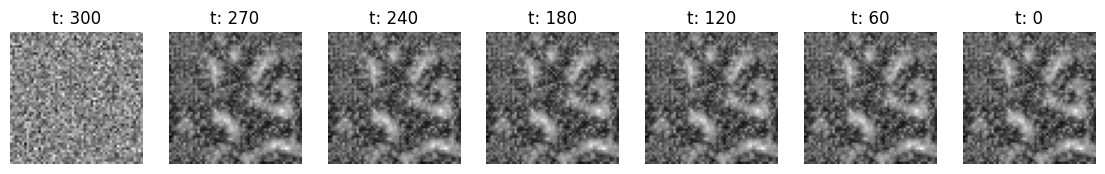

In [8]:
T = diffusion_model.timestep
plot_reverse_diffusion(
    rec_sec_image,
    sequence_t=list(map(int, [0, 0.1*T, 0.2*T, 0.4*T, 0.6*T, 0.8*T, T])), 
    diffusion_step=diffusion_model.timestep)

In [9]:
rec_sec_image[1]

tensor([[[[-68.3297,   4.2078, -35.5055,  ..., -58.6417, -36.1675, -59.5471],
          [  4.7061,  24.6162,  40.4170,  ..., -79.2968, -44.7562,  12.7902],
          [ 45.4248, -45.7824,  16.0310,  ...,   3.7229,  13.3766,   6.6557],
          ...,
          [-33.1085,   2.6322,   9.3658,  ..., -53.9728,  -0.9221, -47.5264],
          [ 24.3598, -12.1491, -69.5099,  ..., -36.5937,  -1.1174, -58.1928],
          [-58.9184, -32.6313, -20.0322,  ...,  43.3004,  -4.0512, -31.9525]]]],
       device='cuda:0')

### Generation

In [10]:
image_shape = torch.Size([1, channels, image_size, image_size])
batch_gen_images = diffusion_model.generate_reverse_sampling(image_shape)

reverse process: 24it [00:00, 121.19it/s]

t: tensor([299], device='cuda:0')
epsilon_theta: tensor([[[[ 1.5503, -0.5139, -0.5491,  ...,  3.3116,  2.1319, -1.0812],
          [ 0.1382,  0.9508,  0.1843,  ..., -0.8860, -0.5377,  1.7060],
          [ 0.6976, -0.6900,  1.0292,  ..., -1.7005,  0.2238, -0.5366],
          ...,
          [-0.6213, -2.6534, -2.2971,  ..., -0.8179,  1.2562, -2.1639],
          [ 1.4018,  1.8449, -3.4504,  ..., -0.9144,  2.2444,  0.5629],
          [-0.2846,  1.5527, -0.2175,  ...,  0.5002, -1.6081, -1.4860]]]],
       device='cuda:0')

t: tensor([298], device='cuda:0')
epsilon_theta: tensor([[[[-3.1643, -0.4165, -0.5733,  ..., -2.8074, -2.7082,  0.8090],
          [-1.4508, -1.9671, -1.0113,  ...,  0.7232,  0.0447, -1.2678],
          [-2.3306,  0.0260, -1.7197,  ...,  1.4098, -0.2766,  0.9817],
          ...,
          [-0.2866,  1.6454,  1.8158,  ..., -0.3571, -2.0240,  1.4591],
          [-3.1868, -1.8317,  2.2976,  ..., -0.0963, -2.7073, -1.3652],
          [-0.8348, -2.6013, -0.6045,  ..., -1.9474,

reverse process: 51it [00:00, 89.61it/s] 

t: tensor([269], device='cuda:0')
epsilon_theta: tensor([[[[-3.1140, -0.3810, -0.5619,  ..., -2.7779, -2.6393,  0.8162],
          [-1.3942, -1.9655, -1.1052,  ...,  0.7079,  0.0526, -1.2353],
          [-2.3436,  0.0416, -1.7494,  ...,  1.4222, -0.3269,  1.0112],
          ...,
          [-0.1983,  1.6400,  1.7930,  ..., -0.3063, -2.0913,  1.4582],
          [-3.1423, -1.8314,  2.3268,  ..., -0.0985, -2.7080, -1.3216],
          [-0.8210, -2.6015, -0.6263,  ..., -1.9323,  1.1228,  0.9057]]]],
       device='cuda:0')

t: tensor([268], device='cuda:0')
epsilon_theta: tensor([[[[-3.1156, -0.3809, -0.5619,  ..., -2.7759, -2.6369,  0.8163],
          [-1.3928, -1.9668, -1.1046,  ...,  0.7080,  0.0525, -1.2353],
          [-2.3439,  0.0413, -1.7515,  ...,  1.4226, -0.3270,  1.0115],
          ...,
          [-0.1981,  1.6404,  1.7931,  ..., -0.3067, -2.0909,  1.4583],
          [-3.1444, -1.8331,  2.3269,  ..., -0.0984, -2.7049, -1.3225],
          [-0.8198, -2.6022, -0.6267,  ..., -1.9357,

reverse process: 62it [00:00, 74.77it/s]

t: tensor([246], device='cuda:0')
epsilon_theta: tensor([[[[-3.1144, -0.3789, -0.5630,  ..., -2.7719, -2.6330,  0.8160],
          [-1.3901, -1.9646, -1.1037,  ...,  0.7093,  0.0534, -1.2334],
          [-2.3437,  0.0409, -1.7536,  ...,  1.4226, -0.3282,  1.0114],
          ...,
          [-0.1967,  1.6409,  1.7926,  ..., -0.3053, -2.0919,  1.4589],
          [-3.1423, -1.8329,  2.3274,  ..., -0.0981, -2.7069, -1.3204],
          [-0.8185, -2.6000, -0.6265,  ..., -1.9339,  1.1224,  0.9056]]]],
       device='cuda:0')

t: tensor([245], device='cuda:0')
epsilon_theta: tensor([[[[-3.1149, -0.3786, -0.5624,  ..., -2.7769, -2.6339,  0.8160],
          [-1.3905, -1.9647, -1.1040,  ...,  0.7094,  0.0533, -1.2337],
          [-2.3409,  0.0410, -1.7536,  ...,  1.4228, -0.3282,  1.0112],
          ...,
          [-0.1967,  1.6411,  1.7924,  ..., -0.3058, -2.0911,  1.4585],
          [-3.1422, -1.8320,  2.3273,  ..., -0.0983, -2.7071, -1.3216],
          [-0.8183, -2.6016, -0.6262,  ..., -1.9333,

reverse process: 76it [00:00, 76.12it/s]

t: tensor([229], device='cuda:0')
epsilon_theta: tensor([[[[-3.1113, -0.3781, -0.5624,  ..., -2.7737, -2.6338,  0.8165],
          [-1.3897, -1.9641, -1.1031,  ...,  0.7087,  0.0534, -1.2347],
          [-2.3407,  0.0409, -1.7537,  ...,  1.4229, -0.3283,  1.0109],
          ...,
          [-0.1965,  1.6411,  1.7930,  ..., -0.3058, -2.0909,  1.4582],
          [-3.1433, -1.8322,  2.3271,  ..., -0.0975, -2.7059, -1.3205],
          [-0.8183, -2.6003, -0.6255,  ..., -1.9331,  1.1222,  0.9054]]]],
       device='cuda:0')

t: tensor([228], device='cuda:0')
epsilon_theta: tensor([[[[-3.1153, -0.3784, -0.5619,  ..., -2.7726, -2.6300,  0.8168],
          [-1.3909, -1.9639, -1.1040,  ...,  0.7086,  0.0536, -1.2339],
          [-2.3423,  0.0410, -1.7541,  ...,  1.4226, -0.3280,  1.0110],
          ...,
          [-0.1965,  1.6415,  1.7929,  ..., -0.3058, -2.0899,  1.4584],
          [-3.1406, -1.8310,  2.3267,  ..., -0.0974, -2.7054, -1.3202],
          [-0.8179, -2.6008, -0.6258,  ..., -1.9327,

reverse process: 85it [00:01, 71.77it/s]

epsilon_theta: tensor([[[[-3.1144, -0.3786, -0.5616,  ..., -2.7749, -2.6323,  0.8168],
          [-1.3906, -1.9637, -1.1042,  ...,  0.7085,  0.0535, -1.2345],
          [-2.3407,  0.0411, -1.7550,  ...,  1.4227, -0.3282,  1.0111],
          ...,
          [-0.1962,  1.6411,  1.7928,  ..., -0.3059, -2.0907,  1.4585],
          [-3.1416, -1.8328,  2.3265,  ..., -0.0968, -2.7085, -1.3192],
          [-0.8185, -2.6009, -0.6258,  ..., -1.9337,  1.1221,  0.9054]]]],
       device='cuda:0')

t: tensor([222], device='cuda:0')
epsilon_theta: tensor([[[[-3.1120, -0.3778, -0.5619,  ..., -2.7759, -2.6356,  0.8168],
          [-1.3903, -1.9626, -1.1034,  ...,  0.7085,  0.0534, -1.2339],
          [-2.3418,  0.0412, -1.7543,  ...,  1.4225, -0.3282,  1.0111],
          ...,
          [-0.1959,  1.6411,  1.7932,  ..., -0.3060, -2.0906,  1.4585],
          [-3.1418, -1.8303,  2.3264,  ..., -0.0966, -2.7084, -1.3208],
          [-0.8188, -2.5975, -0.6259,  ..., -1.9331,  1.1222,  0.9054]]]],
       devi

reverse process: 110it [00:01, 75.14it/s]

t: tensor([204], device='cuda:0')
epsilon_theta: tensor([[[[-3.1129, -0.3779, -0.5615,  ..., -2.7723, -2.6331,  0.8167],
          [-1.3901, -1.9660, -1.1043,  ...,  0.7085,  0.0532, -1.2334],
          [-2.3421,  0.0412, -1.7541,  ...,  1.4229, -0.3288,  1.0114],
          ...,
          [-0.1964,  1.6419,  1.7930,  ..., -0.3058, -2.0920,  1.4579],
          [-3.1429, -1.8322,  2.3265,  ..., -0.0963, -2.7064, -1.3206],
          [-0.8187, -2.6003, -0.6269,  ..., -1.9354,  1.1229,  0.9060]]]],
       device='cuda:0')

t: tensor([203], device='cuda:0')
epsilon_theta: tensor([[[[-3.1136, -0.3782, -0.5615,  ..., -2.7719, -2.6340,  0.8168],
          [-1.3905, -1.9651, -1.1036,  ...,  0.7085,  0.0532, -1.2343],
          [-2.3420,  0.0411, -1.7534,  ...,  1.4231, -0.3288,  1.0117],
          ...,
          [-0.1964,  1.6419,  1.7931,  ..., -0.3055, -2.0934,  1.4580],
          [-3.1409, -1.8330,  2.3268,  ..., -0.0964, -2.7086, -1.3207],
          [-0.8192, -2.6009, -0.6255,  ..., -1.9327,

reverse process: 133it [00:01, 74.42it/s]

epsilon_theta: tensor([[[[-3.1117, -0.3778, -0.5616,  ..., -2.7738, -2.6346,  0.8164],
          [-1.3911, -1.9625, -1.1044,  ...,  0.7086,  0.0533, -1.2343],
          [-2.3408,  0.0407, -1.7541,  ...,  1.4232, -0.3293,  1.0116],
          ...,
          [-0.1963,  1.6419,  1.7931,  ..., -0.3056, -2.0912,  1.4581],
          [-3.1417, -1.8315,  2.3263,  ..., -0.0962, -2.7068, -1.3209],
          [-0.8188, -2.6017, -0.6261,  ..., -1.9326,  1.1229,  0.9059]]]],
       device='cuda:0')

t: tensor([184], device='cuda:0')
epsilon_theta: tensor([[[[-3.1112, -0.3781, -0.5622,  ..., -2.7742, -2.6320,  0.8166],
          [-1.3900, -1.9651, -1.1041,  ...,  0.7086,  0.0532, -1.2337],
          [-2.3430,  0.0406, -1.7546,  ...,  1.4231, -0.3293,  1.0116],
          ...,
          [-0.1963,  1.6420,  1.7931,  ..., -0.3052, -2.0932,  1.4582],
          [-3.1390, -1.8340,  2.3266,  ..., -0.0960, -2.7077, -1.3194],
          [-0.8180, -2.6001, -0.6256,  ..., -1.9326,  1.1230,  0.9059]]]],
       devi

reverse process: 143it [00:02, 60.52it/s]

t: tensor([166], device='cuda:0')
epsilon_theta: tensor([[[[-3.1137, -0.3776, -0.5617,  ..., -2.7722, -2.6350,  0.8163],
          [-1.3915, -1.9646, -1.1046,  ...,  0.7086,  0.0532, -1.2328],
          [-2.3415,  0.0405, -1.7538,  ...,  1.4229, -0.3292,  1.0116],
          ...,
          [-0.1962,  1.6421,  1.7932,  ..., -0.3051, -2.0926,  1.4582],
          [-3.1446, -1.8317,  2.3267,  ..., -0.0959, -2.7061, -1.3204],
          [-0.8183, -2.5999, -0.6261,  ..., -1.9343,  1.1228,  0.9061]]]],
       device='cuda:0')

t: tensor([165], device='cuda:0')
epsilon_theta: tensor([[[[-3.1114, -0.3777, -0.5618,  ..., -2.7739, -2.6335,  0.8164],
          [-1.3896, -1.9658, -1.1041,  ...,  0.7086,  0.0532, -1.2338],
          [-2.3436,  0.0404, -1.7546,  ...,  1.4231, -0.3292,  1.0115],
          ...,
          [-0.1964,  1.6420,  1.7929,  ..., -0.3052, -2.0908,  1.4583],
          [-3.1410, -1.8334,  2.3268,  ..., -0.0957, -2.7056, -1.3200],
          [-0.8184, -2.5979, -0.6256,  ..., -1.9321,

reverse process: 157it [00:02, 75.13it/s]

t: tensor([150], device='cuda:0')
epsilon_theta: tensor([[[[-3.1119, -0.3776, -0.5617,  ..., -2.7733, -2.6349,  0.8168],
          [-1.3892, -1.9651, -1.1038,  ...,  0.7084,  0.0533, -1.2337],
          [-2.3416,  0.0405, -1.7552,  ...,  1.4232, -0.3294,  1.0117],
          ...,
          [-0.1958,  1.6421,  1.7932,  ..., -0.3052, -2.0915,  1.4585],
          [-3.1422, -1.8341,  2.3271,  ..., -0.0958, -2.7056, -1.3200],
          [-0.8185, -2.5970, -0.6256,  ..., -1.9334,  1.1228,  0.9057]]]],
       device='cuda:0')

t: tensor([149], device='cuda:0')
epsilon_theta: tensor([[[[-3.1141, -0.3774, -0.5620,  ..., -2.7735, -2.6351,  0.8167],
          [-1.3893, -1.9636, -1.1055,  ...,  0.7085,  0.0533, -1.2332],
          [-2.3423,  0.0405, -1.7545,  ...,  1.4232, -0.3294,  1.0116],
          ...,
          [-0.1960,  1.6417,  1.7933,  ..., -0.3054, -2.0925,  1.4583],
          [-3.1407, -1.8317,  2.3270,  ..., -0.0957, -2.7091, -1.3209],
          [-0.8173, -2.6009, -0.6261,  ..., -1.9326,

reverse process: 167it [00:02, 64.81it/s]

t: tensor([141], device='cuda:0')
epsilon_theta: tensor([[[[-3.1125, -0.3775, -0.5620,  ..., -2.7761, -2.6320,  0.8164],
          [-1.3901, -1.9625, -1.1034,  ...,  0.7086,  0.0533, -1.2338],
          [-2.3389,  0.0407, -1.7560,  ...,  1.4232, -0.3293,  1.0116],
          ...,
          [-0.1961,  1.6416,  1.7932,  ..., -0.3053, -2.0929,  1.4584],
          [-3.1424, -1.8315,  2.3273,  ..., -0.0956, -2.7083, -1.3202],
          [-0.8181, -2.6003, -0.6254,  ..., -1.9318,  1.1230,  0.9059]]]],
       device='cuda:0')

t: tensor([140], device='cuda:0')
epsilon_theta: tensor([[[[-3.1130, -0.3775, -0.5620,  ..., -2.7718, -2.6334,  0.8168],
          [-1.3900, -1.9651, -1.1042,  ...,  0.7085,  0.0534, -1.2332],
          [-2.3416,  0.0407, -1.7535,  ...,  1.4231, -0.3295,  1.0118],
          ...,
          [-0.1959,  1.6417,  1.7931,  ..., -0.3051, -2.0933,  1.4585],
          [-3.1408, -1.8307,  2.3266,  ..., -0.0956, -2.7101, -1.3208],
          [-0.8180, -2.5971, -0.6255,  ..., -1.9332,

reverse process: 191it [00:02, 70.62it/s]

t: tensor([123], device='cuda:0')
epsilon_theta: tensor([[[[-3.1160, -0.3770, -0.5622,  ..., -2.7709, -2.6326,  0.8166],
          [-1.3902, -1.9643, -1.1051,  ...,  0.7086,  0.0534, -1.2328],
          [-2.3408,  0.0408, -1.7552,  ...,  1.4233, -0.3300,  1.0117],
          ...,
          [-0.1957,  1.6417,  1.7934,  ..., -0.3052, -2.0928,  1.4581],
          [-3.1400, -1.8321,  2.3269,  ..., -0.0956, -2.7069, -1.3196],
          [-0.8183, -2.5990, -0.6257,  ..., -1.9332,  1.1229,  0.9059]]]],
       device='cuda:0')

t: tensor([122], device='cuda:0')
epsilon_theta: tensor([[[[-3.1117, -0.3772, -0.5615,  ..., -2.7742, -2.6329,  0.8165],
          [-1.3888, -1.9644, -1.1042,  ...,  0.7086,  0.0534, -1.2344],
          [-2.3409,  0.0408, -1.7557,  ...,  1.4231, -0.3298,  1.0118],
          ...,
          [-0.1958,  1.6415,  1.7933,  ..., -0.3052, -2.0921,  1.4584],
          [-3.1396, -1.8325,  2.3269,  ..., -0.0955, -2.7065, -1.3215],
          [-0.8183, -2.5988, -0.6253,  ..., -1.9342,

reverse process: 200it [00:02, 70.42it/s]

epsilon_theta: tensor([[[[-3.1122, -0.3774, -0.5617,  ..., -2.7709, -2.6333,  0.8165],
          [-1.3900, -1.9635, -1.1048,  ...,  0.7086,  0.0533, -1.2335],
          [-2.3429,  0.0408, -1.7559,  ...,  1.4234, -0.3300,  1.0118],
          ...,
          [-0.1956,  1.6419,  1.7938,  ..., -0.3049, -2.0930,  1.4585],
          [-3.1425, -1.8306,  2.3270,  ..., -0.0954, -2.7071, -1.3203],
          [-0.8181, -2.6008, -0.6259,  ..., -1.9316,  1.1229,  0.9060]]]],
       device='cuda:0')

t: tensor([106], device='cuda:0')
epsilon_theta: tensor([[[[-3.1144, -0.3771, -0.5619,  ..., -2.7724, -2.6330,  0.8167],
          [-1.3901, -1.9647, -1.1036,  ...,  0.7085,  0.0534, -1.2336],
          [-2.3408,  0.0408, -1.7560,  ...,  1.4234, -0.3300,  1.0118],
          ...,
          [-0.1956,  1.6419,  1.7933,  ..., -0.3049, -2.0916,  1.4584],
          [-3.1399, -1.8322,  2.3270,  ..., -0.0952, -2.7088, -1.3205],
          [-0.8190, -2.5992, -0.6256,  ..., -1.9333,  1.1228,  0.9061]]]],
       devi

reverse process: 223it [00:03, 85.23it/s]

t: tensor([96], device='cuda:0')
epsilon_theta: tensor([[[[-3.1152, -0.3770, -0.5612,  ..., -2.7720, -2.6358,  0.8166],
          [-1.3896, -1.9628, -1.1047,  ...,  0.7086,  0.0533, -1.2324],
          [-2.3420,  0.0409, -1.7543,  ...,  1.4235, -0.3298,  1.0117],
          ...,
          [-0.1956,  1.6416,  1.7936,  ..., -0.3048, -2.0932,  1.4585],
          [-3.1405, -1.8311,  2.3273,  ..., -0.0952, -2.7073, -1.3199],
          [-0.8172, -2.6008, -0.6259,  ..., -1.9319,  1.1229,  0.9059]]]],
       device='cuda:0')

t: tensor([95], device='cuda:0')
epsilon_theta: tensor([[[[-3.1122, -0.3770, -0.5616,  ..., -2.7714, -2.6352,  0.8167],
          [-1.3897, -1.9629, -1.1035,  ...,  0.7084,  0.0533, -1.2327],
          [-2.3414,  0.0409, -1.7548,  ...,  1.4233, -0.3301,  1.0119],
          ...,
          [-0.1955,  1.6417,  1.7934,  ..., -0.3049, -2.0935,  1.4582],
          [-3.1388, -1.8339,  2.3267,  ..., -0.0952, -2.7087, -1.3203],
          [-0.8191, -2.5987, -0.6262,  ..., -1.9330,  

reverse process: 233it [00:03, 71.40it/s]

t: tensor([75], device='cuda:0')
epsilon_theta: tensor([[[[-3.1135, -0.3767, -0.5617,  ..., -2.7706, -2.6320,  0.8166],
          [-1.3884, -1.9627, -1.1033,  ...,  0.7088,  0.0534, -1.2336],
          [-2.3425,  0.0409, -1.7549,  ...,  1.4234, -0.3299,  1.0117],
          ...,
          [-0.1953,  1.6420,  1.7937,  ..., -0.3046, -2.0929,  1.4582],
          [-3.1425, -1.8303,  2.3271,  ..., -0.0951, -2.7080, -1.3200],
          [-0.8175, -2.5992, -0.6257,  ..., -1.9327,  1.1231,  0.9061]]]],
       device='cuda:0')

t: tensor([74], device='cuda:0')
epsilon_theta: tensor([[[[-3.1138, -0.3765, -0.5620,  ..., -2.7747, -2.6336,  0.8166],
          [-1.3895, -1.9638, -1.1043,  ...,  0.7088,  0.0534, -1.2339],
          [-2.3416,  0.0409, -1.7529,  ...,  1.4235, -0.3302,  1.0117],
          ...,
          [-0.1954,  1.6419,  1.7938,  ..., -0.3046, -2.0920,  1.4582],
          [-3.1423, -1.8325,  2.3269,  ..., -0.0949, -2.7082, -1.3204],
          [-0.8185, -2.5984, -0.6259,  ..., -1.9327,  

reverse process: 246it [00:03, 61.92it/s]

t: tensor([57], device='cuda:0')
epsilon_theta: tensor([[[[-3.1136, -0.3767, -0.5612,  ..., -2.7734, -2.6331,  0.8168],
          [-1.3895, -1.9643, -1.1041,  ...,  0.7090,  0.0534, -1.2332],
          [-2.3408,  0.0409, -1.7556,  ...,  1.4237, -0.3302,  1.0117],
          ...,
          [-0.1951,  1.6422,  1.7938,  ..., -0.3041, -2.0943,  1.4582],
          [-3.1410, -1.8317,  2.3270,  ..., -0.0948, -2.7083, -1.3197],
          [-0.8180, -2.6006, -0.6258,  ..., -1.9335,  1.1232,  0.9062]]]],
       device='cuda:0')

t: tensor([56], device='cuda:0')
epsilon_theta: tensor([[[[-3.1130, -0.3766, -0.5616,  ..., -2.7710, -2.6316,  0.8168],
          [-1.3873, -1.9638, -1.1035,  ...,  0.7090,  0.0534, -1.2342],
          [-2.3404,  0.0409, -1.7578,  ...,  1.4234, -0.3304,  1.0118],
          ...,
          [-0.1951,  1.6419,  1.7938,  ..., -0.3043, -2.0950,  1.4585],
          [-3.1419, -1.8313,  2.3273,  ..., -0.0948, -2.7082, -1.3197],
          [-0.8177, -2.6008, -0.6255,  ..., -1.9324,  

reverse process: 274it [00:03, 89.21it/s]

t: tensor([52], device='cuda:0')
epsilon_theta: tensor([[[[-3.1128, -0.3768, -0.5614,  ..., -2.7712, -2.6348,  0.8168],
          [-1.3882, -1.9634, -1.1051,  ...,  0.7091,  0.0535, -1.2334],
          [-2.3431,  0.0409, -1.7568,  ...,  1.4234, -0.3306,  1.0119],
          ...,
          [-0.1950,  1.6419,  1.7937,  ..., -0.3041, -2.0944,  1.4584],
          [-3.1396, -1.8324,  2.3272,  ..., -0.0948, -2.7078, -1.3210],
          [-0.8182, -2.5997, -0.6255,  ..., -1.9324,  1.1232,  0.9061]]]],
       device='cuda:0')

t: tensor([51], device='cuda:0')
epsilon_theta: tensor([[[[-3.1125, -0.3767, -0.5617,  ..., -2.7726, -2.6350,  0.8167],
          [-1.3888, -1.9647, -1.1048,  ...,  0.7092,  0.0535, -1.2333],
          [-2.3435,  0.0409, -1.7568,  ...,  1.4234, -0.3305,  1.0118],
          ...,
          [-0.1951,  1.6420,  1.7938,  ..., -0.3044, -2.0946,  1.4584],
          [-3.1402, -1.8318,  2.3277,  ..., -0.0948, -2.7085, -1.3210],
          [-0.8171, -2.5982, -0.6254,  ..., -1.9340,  

reverse process: 285it [00:03, 85.57it/s]

t: tensor([24], device='cuda:0')
epsilon_theta: tensor([[[[-3.1143, -0.3756, -0.5614,  ..., -2.7732, -2.6315,  0.8169],
          [-1.3875, -1.9632, -1.1038,  ...,  0.7092,  0.0534, -1.2341],
          [-2.3432,  0.0409, -1.7563,  ...,  1.4237, -0.3307,  1.0118],
          ...,
          [-0.1943,  1.6420,  1.7938,  ..., -0.3039, -2.0949,  1.4586],
          [-3.1400, -1.8328,  2.3275,  ..., -0.0941, -2.7085, -1.3204],
          [-0.8162, -2.5997, -0.6255,  ..., -1.9311,  1.1235,  0.9063]]]],
       device='cuda:0')

t: tensor([23], device='cuda:0')
epsilon_theta: tensor([[[[-3.1153, -0.3758, -0.5616,  ..., -2.7741, -2.6349,  0.8170],
          [-1.3883, -1.9620, -1.1044,  ...,  0.7094,  0.0534, -1.2334],
          [-2.3431,  0.0409, -1.7552,  ...,  1.4237, -0.3311,  1.0118],
          ...,
          [-0.1943,  1.6420,  1.7937,  ..., -0.3039, -2.0947,  1.4585],
          [-3.1409, -1.8315,  2.3279,  ..., -0.0941, -2.7096, -1.3209],
          [-0.8163, -2.6016, -0.6256,  ..., -1.9326,  

reverse process: 300it [00:03, 75.09it/s]

t: tensor([3], device='cuda:0')
epsilon_theta: tensor([[[[-3.1179, -0.3741, -0.5597,  ..., -2.7749, -2.6406,  0.8175],
          [-1.3854, -1.9627, -1.1033,  ...,  0.7098,  0.0534, -1.2352],
          [-2.3450,  0.0410, -1.7568,  ...,  1.4239, -0.3327,  1.0124],
          ...,
          [-0.1923,  1.6423,  1.7943,  ..., -0.3020, -2.0971,  1.4589],
          [-3.1429, -1.8323,  2.3285,  ..., -0.0925, -2.7101, -1.3213],
          [-0.8145, -2.6034, -0.6236,  ..., -1.9313,  1.1238,  0.9067]]]],
       device='cuda:0')

t: tensor([2], device='cuda:0')
epsilon_theta: tensor([[[[-3.1161, -0.3736, -0.5607,  ..., -2.7744, -2.6364,  0.8176],
          [-1.3872, -1.9630, -1.1044,  ...,  0.7098,  0.0534, -1.2356],
          [-2.3454,  0.0410, -1.7572,  ...,  1.4240, -0.3332,  1.0124],
          ...,
          [-0.1921,  1.6419,  1.7943,  ..., -0.3019, -2.0985,  1.4594],
          [-3.1459, -1.8340,  2.3284,  ..., -0.0926, -2.7109, -1.3201],
          [-0.8147, -2.6014, -0.6246,  ..., -1.9312,  1.

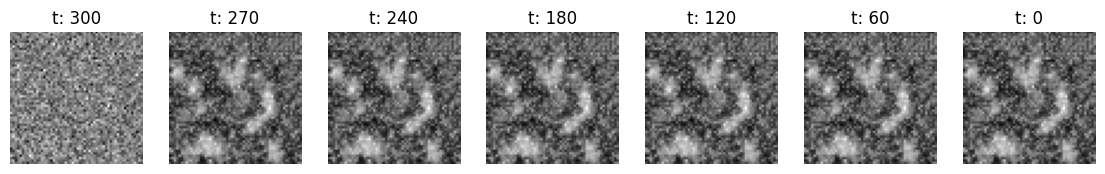

In [11]:
plot_reverse_diffusion(
    batch_gen_images, 
    sequence_t=list(map(int, [0, 0.1*T, 0.2*T, 0.4*T, 0.6*T, 0.8*T, T])), 
    diffusion_step=diffusion_model.timestep
)

In [12]:
batch_gen_images[-1][0].std()

tensor(8402.2227, device='cuda:0')